In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v6 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-13 20:50:54.342534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 20:50:54.342871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 20:50:54.375057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 20:50:54.375400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 20:50:54.375687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_040'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_040
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

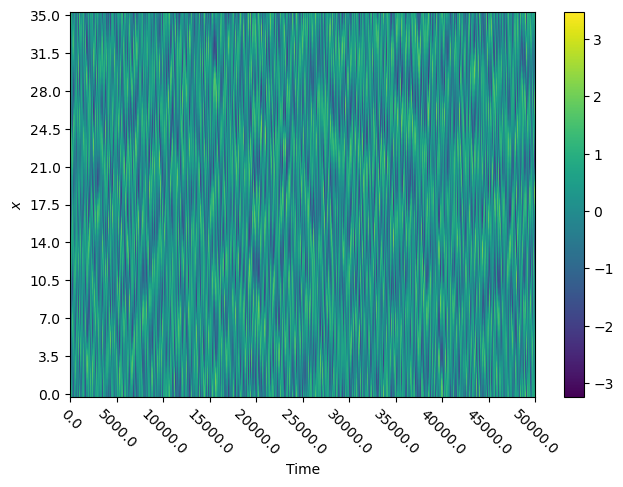

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([10, 30, 50])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [5e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
35/35 [==============================] - ETA: 0s - loss: 0.0085 - mse: 8.9991e-04 - covmat_fro_loss: 7.1061e-04 - tot_time: 0h 0m 20.4s

Epoch 1: val_loss improved from inf to 0.00881, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 151ms/step - loss: 0.0072 - mse: 7.5579e-04 - covmat_fro_loss: 6.5792e-04 - val_loss: 0.0082 - val_mse: 8.6669e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
35/35 [==============================] - ETA: 0s - loss: 0.0071 - mse: 7.4993e-04 - covmat_fro_loss: 6.5469e-04 - tot_time: 0h 1m 27.5s

Epoch 14: val_loss did not improve from 0.00819
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0071 - mse: 7.4993e-04 - covmat_fro_loss: 6.5455e-04 - val_loss: 0.0082 - val_mse: 8.6728e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
35/35 [==============================] - ETA: 0s - loss: 0.0071 - mse: 7.4277e-04 - covmat_fro_loss: 6.5209

Epoch 27/1000
35/35 [==============================] - ETA: 0s - loss: 0.0066 - mse: 6.8929e-04 - covmat_fro_loss: 6.3152e-04 - tot_time: 0h 2m 34.4s

Epoch 27: val_loss did not improve from 0.00772
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0066 - mse: 6.8929e-04 - covmat_fro_loss: 6.3120e-04 - val_loss: 0.0078 - val_mse: 8.2433e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 28/1000
35/35 [==============================] - ETA: 0s - loss: 0.0065 - mse: 6.8209e-04 - covmat_fro_loss: 6.2841e-04 - tot_time: 0h 2m 39.4s

Epoch 28: val_loss did not improve from 0.00772
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0065 - mse: 6.8209e-04 - covmat_fro_loss: 6.2896e-

Epoch 41/1000
35/35 [==============================] - ETA: 0s - loss: 0.0061 - mse: 6.3891e-04 - covmat_fro_loss: 6.1000e-04 - tot_time: 0h 3m 44.8s

Epoch 41: val_loss improved from 0.00740 to 0.00738, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0061 - mse: 6.3891e-04 - covmat_fro_loss: 6.0937e-04 - val_loss: 0.0074 - val_mse: 7.7599e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 42/1000
35/35 [==============================] - ETA: 0s - loss: 0.0061 - mse: 6.3768e-04 - covmat_fro_loss: 6.0926e-04 - tot_time: 0h 3m 49.8s

Epoch 42: val_loss improved from 0.00738 to 0.00737, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - savin

Epoch 55/1000
35/35 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.9908e-04 - covmat_fro_loss: 5.9224e-04 - tot_time: 0h 4m 54.5s

Epoch 55: val_loss did not improve from 0.00716
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0058 - mse: 5.9908e-04 - covmat_fro_loss: 5.9214e-04 - val_loss: 0.0072 - val_mse: 7.5342e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 56/1000
35/35 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.9720e-04 - covmat_fro_loss: 5.9134e-04 - tot_time: 0h 4m 59.4s

Epoch 56: val_loss improved from 0.00716 to 0.00711, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0055 - mse: 5.7021e-04 - covmat_fro_loss: 5.7915e-04 - val_loss: 0.0069 - val_mse: 7.2409e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 69/1000
35/35 [==============================] - ETA: 0s - loss: 0.0055 - mse: 5.6537e-04 - covmat_fro_loss: 5.7690e-04 - tot_time: 0h 6m 4.8s

Epoch 69: val_loss improved from 0.00688 to 0.00683, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0055 - mse: 5.6537e-04 - covmat_fro_loss: 5.7745e-04 - val_loss: 0.0068 - val_mse: 7.1559e-04 - val_covmat_fro_loss: 0.0000

35/35 [==============================] - ETA: 0s - loss: 0.0053 - mse: 5.4085e-04 - covmat_fro_loss: 5.6503e-04 - tot_time: 0h 7m 10.5s

Epoch 82: val_loss improved from 0.00671 to 0.00666, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0053 - mse: 5.4085e-04 - covmat_fro_loss: 5.6498e-04 - val_loss: 0.0067 - val_mse: 6.9672e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 83/1000
35/35 [==============================] - ETA: 0s - loss: 0.0053 - mse: 5.4170e-04 - covmat_fro_loss: 5.6553e-04 - tot_time: 0h 7m 15.6s

Epoch 83: val_loss did not improve from 0.00666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0050 - mse: 5.1693e-04 - covmat_fro_loss: 5.5238e-04 - val_loss: 0.0065 - val_mse: 6.7500e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 96/1000
35/35 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.1676e-04 - covmat_fro_loss: 5.5321e-04 - tot_time: 0h 8m 20.6s

Epoch 96: val_loss improved from 0.00647 to 0.00647, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0050 - mse: 5.1676e-04 - covmat_fro_loss: 5.5286e-04 - val_loss: 0.0065 - val_mse: 6.7474e-04 - val_covmat_fro_loss: 0.000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0049 - mse: 4.9591e-04 - covmat_fro_loss: 5.4395e-04 - val_loss: 0.0063 - val_mse: 6.6007e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 110/1000
35/35 [==============================] - ETA: 0s - loss: 0.0049 - mse: 4.9603e-04 - covmat_fro_loss: 5.4244e-04 - tot_time: 0h 9m 31.4s

Epoch 110: val_loss improved from 0.00633 to 0.00626, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0049 - mse: 4.9603e-04 - covmat_fro_loss: 5.4208e-04 - val_loss: 0.0063 - val_mse: 6.5149e-04 - val_covmat_fro_loss: 0.0

Epoch 124/1000
35/35 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7340e-04 - covmat_fro_loss: 5.3109e-04 - tot_time: 0h 10m 42.8s

Epoch 124: val_loss did not improve from 0.00617
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0047 - mse: 4.7340e-04 - covmat_fro_loss: 5.3039e-04 - val_loss: 0.0062 - val_mse: 6.4562e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 125/1000
35/35 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7451e-04 - covmat_fro_loss: 5.3186e-04 - tot_time: 0h 10m 48.0s

Epoch 125: val_loss did not improve from 0.00617
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0047 - mse: 4.7451e-04 - covmat_fro_loss: 5.

35/35 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5801e-04 - covmat_fro_loss: 5.2272e-04 - tot_time: 0h 11m 54.6s

Epoch 138: val_loss did not improve from 0.00602
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0045 - mse: 4.5801e-04 - covmat_fro_loss: 5.2336e-04 - val_loss: 0.0061 - val_mse: 6.3662e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 139/1000
35/35 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5757e-04 - covmat_fro_loss: 5.2259e-04 - tot_time: 0h 11m 59.8s

Epoch 139: val_loss improved from 0.00602 to 0.00601, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outste

Epoch 152/1000
35/35 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4125e-04 - covmat_fro_loss: 5.1395e-04 - tot_time: 0h 13m 5.8s

Epoch 152: val_loss improved from 0.00589 to 0.00585, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0044 - mse: 4.4125e-04 - covmat_fro_loss: 5.1388e-04 - val_loss: 0.0059 - val_mse: 6.0675e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 153/1000
35/35 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3938e-04 - covmat_fro_loss: 5.1251e-04 - tot_time: 0h 13m 10.9s

Epoch 153: val_loss did not improve from 0.00585
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckp

Epoch 166/1000
35/35 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2727e-04 - covmat_fro_loss: 5.0591e-04 - tot_time: 0h 14m 17.3s

Epoch 166: val_loss did not improve from 0.00575
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0042 - mse: 4.2727e-04 - covmat_fro_loss: 5.0587e-04 - val_loss: 0.0058 - val_mse: 5.9621e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 167/1000
35/35 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2683e-04 - covmat_fro_loss: 5.0575e-04 - tot_time: 0h 14m 22.3s

Epoch 167: val_loss improved from 0.00575 to 0.00574, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 180/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1383e-04 - covmat_fro_loss: 4.9834e-04 - tot_time: 0h 15m 28.5s

Epoch 180: val_loss did not improve from 0.00564
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0041 - mse: 4.1383e-04 - covmat_fro_loss: 4.9884e-04 - val_loss: 0.0058 - val_mse: 5.9676e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 181/1000
35/35 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1298e-04 - covmat_fro_loss: 4.9799e-04 - tot_time: 0h 15m 33.6s

Epoch 181: val_loss improved from 0.00564 to 0.00564, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0040 - mse: 3.9727e-04 - covmat_fro_loss: 4.8885e-04 - val_loss: 0.0055 - val_mse: 5.6635e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 194/1000
35/35 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.9920e-04 - covmat_fro_loss: 4.8962e-04 - tot_time: 0h 16m 40.7s

Epoch 194: val_loss did not improve from 0.00549
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0040 - mse: 3.9920e-04 - covmat_fro_loss: 4.9071e-04 - val_loss: 0.0055 - val_mse: 5.7204e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 195/1000
35/35 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.9631e-04 - covmat_fro_loss: 4.

Epoch 208/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.8562e-04 - covmat_fro_loss: 4.8188e-04 - tot_time: 0h 17m 52.3s

Epoch 208: val_loss did not improve from 0.00542
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 151ms/step - loss: 0.0039 - mse: 3.8562e-04 - covmat_fro_loss: 4.8146e-04 - val_loss: 0.0054 - val_mse: 5.5966e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 209/1000
35/35 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.8640e-04 - covmat_fro_loss: 4.8280e-04 - tot_time: 0h 17m 57.4s

Epoch 209: val_loss did not improve from 0.00542
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0039 - mse: 3.8640e-04 - covmat_fro_loss: 4.

Epoch 222/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.7201e-04 - covmat_fro_loss: 4.7374e-04 - tot_time: 0h 19m 3.6s

Epoch 222: val_loss did not improve from 0.00530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0037 - mse: 3.7201e-04 - covmat_fro_loss: 4.7370e-04 - val_loss: 0.0053 - val_mse: 5.4989e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 223/1000
35/35 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7474e-04 - covmat_fro_loss: 4.7515e-04 - tot_time: 0h 19m 8.6s

Epoch 223: val_loss did not improve from 0.00530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0038 - mse: 3.7474e-04 - covmat_fro_loss: 4.75

Epoch 236/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.6431e-04 - covmat_fro_loss: 4.6899e-04 - tot_time: 0h 20m 15.7s

Epoch 236: val_loss improved from 0.00522 to 0.00518, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 152ms/step - loss: 0.0037 - mse: 3.6431e-04 - covmat_fro_loss: 4.6944e-04 - val_loss: 0.0052 - val_mse: 5.3233e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 237/1000
35/35 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.6296e-04 - covmat_fro_loss: 4.6799e-04 - tot_time: 0h 20m 21.0s

Epoch 237: val_loss did not improve from 0.00518
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.5304e-04 - covmat_fro_loss: 4.6178e-04 - tot_time: 0h 21m 26.9s

Epoch 250: val_loss improved from 0.00513 to 0.00512, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0036 - mse: 3.5304e-04 - covmat_fro_loss: 4.6292e-04 - val_loss: 0.0051 - val_mse: 5.2514e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 251/1000
35/35 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.5319e-04 - covmat_fro_loss: 4.6211e-04 - tot_time: 0h 21m 32.1s

Epoch 251: val_loss did not improve from 0.00512
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outste

Epoch 265/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.4292e-04 - covmat_fro_loss: 4.5573e-04 - tot_time: 0h 22m 43.3s

Epoch 265: val_loss improved from 0.00506 to 0.00502, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0035 - mse: 3.4292e-04 - covmat_fro_loss: 4.5603e-04 - val_loss: 0.0050 - val_mse: 5.1441e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 266/1000
35/35 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.4613e-04 - covmat_fro_loss: 4.5755e-04 - tot_time: 0h 22m 48.4s

Epoch 266: val_loss did not improve from 0.00502
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 279/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.3753e-04 - covmat_fro_loss: 4.5206e-04 - tot_time: 0h 23m 54.7s

Epoch 279: val_loss improved from 0.00501 to 0.00496, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 154ms/step - loss: 0.0034 - mse: 3.3753e-04 - covmat_fro_loss: 4.5280e-04 - val_loss: 0.0050 - val_mse: 5.0717e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 280/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.3641e-04 - covmat_fro_loss: 4.5141e-04 - tot_time: 0h 23m 60.0s

Epoch 280: val_loss improved from 0.00496 to 0.00494, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 -

Epoch 294/1000
35/35 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.3027e-04 - covmat_fro_loss: 4.4748e-04 - tot_time: 0h 25m 10.6s

Epoch 294: val_loss did not improve from 0.00490
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0034 - mse: 3.3027e-04 - covmat_fro_loss: 4.4742e-04 - val_loss: 0.0049 - val_mse: 5.0402e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 295/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.2532e-04 - covmat_fro_loss: 4.4393e-04 - tot_time: 0h 25m 15.6s

Epoch 295: val_loss improved from 0.00490 to 0.00488, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.1906e-04 - covmat_fro_loss: 4.3974e-04 - tot_time: 0h 26m 21.9s

Epoch 308: val_loss did not improve from 0.00482
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0033 - mse: 3.1906e-04 - covmat_fro_loss: 4.3944e-04 - val_loss: 0.0049 - val_mse: 4.9782e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 309/1000
35/35 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.2083e-04 - covmat_fro_loss: 4.4121e-04 - tot_time: 0h 26m 27.0s

Epoch 309: val_loss did not improve from 0.00482
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0033 - mse: 3.2083e-04 - covmat_fro_loss: 4.4091e-04 - val_

35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.1123e-04 - covmat_fro_loss: 4.3467e-04 - tot_time: 0h 27m 33.7s

Epoch 322: val_loss did not improve from 0.00479
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0032 - mse: 3.1123e-04 - covmat_fro_loss: 4.3431e-04 - val_loss: 0.0048 - val_mse: 4.9080e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 323/1000
35/35 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.1343e-04 - covmat_fro_loss: 4.3590e-04 - tot_time: 0h 27m 38.7s

Epoch 323: val_loss improved from 0.00479 to 0.00477, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outste

35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.0567e-04 - covmat_fro_loss: 4.3127e-04 - tot_time: 0h 28m 45.1s

Epoch 336: val_loss did not improve from 0.00469
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0031 - mse: 3.0567e-04 - covmat_fro_loss: 4.3152e-04 - val_loss: 0.0047 - val_mse: 4.7980e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 337/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.0397e-04 - covmat_fro_loss: 4.2950e-04 - tot_time: 0h 28m 50.0s

Epoch 337: val_loss did not improve from 0.00469
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0031 - mse: 3.0397e-04 - covmat_fro_loss: 4.2918e-04 - val_

Epoch 351/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.9686e-04 - covmat_fro_loss: 4.2476e-04 - tot_time: 0h 30m 0.5s

Epoch 351: val_loss did not improve from 0.00464
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - loss: 0.0031 - mse: 2.9686e-04 - covmat_fro_loss: 4.2477e-04 - val_loss: 0.0047 - val_mse: 4.7412e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 352/1000
35/35 [==============================] - ETA: 0s - loss: 0.0031 - mse: 2.9818e-04 - covmat_fro_loss: 4.2591e-04 - tot_time: 0h 30m 5.6s

Epoch 352: val_loss improved from 0.00464 to 0.00462, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpo

Epoch 365/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.9367e-04 - covmat_fro_loss: 4.2292e-04 - tot_time: 0h 31m 12.2s

Epoch 365: val_loss did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0030 - mse: 2.9367e-04 - covmat_fro_loss: 4.2242e-04 - val_loss: 0.0046 - val_mse: 4.6748e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 366/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.9298e-04 - covmat_fro_loss: 4.2228e-04 - tot_time: 0h 31m 17.2s

Epoch 366: val_loss did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0030 - mse: 2.9298e-04 - covmat_fro_loss: 4.

Epoch 380/1000
35/35 [==============================] - ETA: 0s - loss: 0.0030 - mse: 2.8519e-04 - covmat_fro_loss: 4.1647e-04 - tot_time: 0h 32m 27.9s

Epoch 380: val_loss improved from 0.00448 to 0.00445, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 151ms/step - loss: 0.0030 - mse: 2.8519e-04 - covmat_fro_loss: 4.1643e-04 - val_loss: 0.0044 - val_mse: 4.5058e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 381/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.8342e-04 - covmat_fro_loss: 4.1551e-04 - tot_time: 0h 32m 33.0s

Epoch 381: val_loss did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 395/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.8060e-04 - covmat_fro_loss: 4.1315e-04 - tot_time: 0h 33m 44.0s

Epoch 395: val_loss did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0029 - mse: 2.8060e-04 - covmat_fro_loss: 4.1361e-04 - val_loss: 0.0045 - val_mse: 4.5336e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 396/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.7844e-04 - covmat_fro_loss: 4.1182e-04 - tot_time: 0h 33m 49.2s

Epoch 396: val_loss did not improve from 0.00443
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0029 - mse: 2.7844e-04 - covmat_fro_loss: 4.

Epoch 410/1000
35/35 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.7357e-04 - covmat_fro_loss: 4.0809e-04 - tot_time: 0h 35m 0.1s

Epoch 410: val_loss did not improve from 0.00439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0029 - mse: 2.7357e-04 - covmat_fro_loss: 4.0818e-04 - val_loss: 0.0044 - val_mse: 4.4626e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 411/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.7131e-04 - covmat_fro_loss: 4.0641e-04 - tot_time: 0h 35m 5.2s

Epoch 411: val_loss did not improve from 0.00439
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0028 - mse: 2.7131e-04 - covmat_fro_loss: 4.06

Epoch 425/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6790e-04 - covmat_fro_loss: 4.0418e-04 - tot_time: 0h 36m 16.6s

Epoch 425: val_loss did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0028 - mse: 2.6790e-04 - covmat_fro_loss: 4.0448e-04 - val_loss: 0.0044 - val_mse: 4.4054e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 426/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6659e-04 - covmat_fro_loss: 4.0316e-04 - tot_time: 0h 36m 21.8s

Epoch 426: val_loss did not improve from 0.00432
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0028 - mse: 2.6659e-04 - covmat_fro_loss: 4.

Epoch 440/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6244e-04 - covmat_fro_loss: 4.0042e-04 - tot_time: 0h 37m 32.8s

Epoch 440: val_loss did not improve from 0.00429
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0028 - mse: 2.6244e-04 - covmat_fro_loss: 3.9996e-04 - val_loss: 0.0044 - val_mse: 4.4183e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 441/1000
35/35 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6264e-04 - covmat_fro_loss: 4.0022e-04 - tot_time: 0h 37m 37.8s

Epoch 441: val_loss improved from 0.00429 to 0.00428, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 454/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.5698e-04 - covmat_fro_loss: 3.9623e-04 - tot_time: 0h 38m 44.6s

Epoch 454: val_loss did not improve from 0.00423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0027 - mse: 2.5698e-04 - covmat_fro_loss: 3.9609e-04 - val_loss: 0.0043 - val_mse: 4.2935e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 455/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.5696e-04 - covmat_fro_loss: 3.9617e-04 - tot_time: 0h 38m 49.6s

Epoch 455: val_loss did not improve from 0.00423
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0027 - mse: 2.5696e-04 - covmat_fro_loss: 3.

Epoch 469/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.5299e-04 - covmat_fro_loss: 3.9289e-04 - tot_time: 0h 40m 0.5s

Epoch 469: val_loss did not improve from 0.00420
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0027 - mse: 2.5299e-04 - covmat_fro_loss: 3.9280e-04 - val_loss: 0.0042 - val_mse: 4.2414e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 470/1000
35/35 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.5357e-04 - covmat_fro_loss: 3.9309e-04 - tot_time: 0h 40m 5.6s

Epoch 470: val_loss improved from 0.00420 to 0.00415, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpo

Epoch 484/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4769e-04 - covmat_fro_loss: 3.8891e-04 - tot_time: 0h 41m 16.8s

Epoch 484: val_loss did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0026 - mse: 2.4769e-04 - covmat_fro_loss: 3.8888e-04 - val_loss: 0.0041 - val_mse: 4.1574e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 485/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4828e-04 - covmat_fro_loss: 3.8932e-04 - tot_time: 0h 41m 21.9s

Epoch 485: val_loss did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0026 - mse: 2.4828e-04 - covmat_fro_loss: 3.

Epoch 499/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4385e-04 - covmat_fro_loss: 3.8588e-04 - tot_time: 0h 42m 33.6s

Epoch 499: val_loss improved from 0.00410 to 0.00409, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0026 - mse: 2.4385e-04 - covmat_fro_loss: 3.8588e-04 - val_loss: 0.0041 - val_mse: 4.1072e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 500/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4182e-04 - covmat_fro_loss: 3.8418e-04 - tot_time: 0h 42m 38.7s

Epoch 500: val_loss did not improve from 0.00409
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3951e-04 - covmat_fro_loss: 3.8258e-04 - tot_time: 0h 43m 45.0s

Epoch 513: val_loss improved from 0.00406 to 0.00405, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 154ms/step - loss: 0.0025 - mse: 2.3951e-04 - covmat_fro_loss: 3.8274e-04 - val_loss: 0.0040 - val_mse: 4.0576e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 514/1000
35/35 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.3966e-04 - covmat_fro_loss: 3.8279e-04 - tot_time: 0h 43m 50.1s

Epoch 514: val_loss did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outste

Epoch 528/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3520e-04 - covmat_fro_loss: 3.7890e-04 - tot_time: 0h 45m 1.1s

Epoch 528: val_loss did not improve from 0.00401
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0025 - mse: 2.3520e-04 - covmat_fro_loss: 3.7851e-04 - val_loss: 0.0041 - val_mse: 4.0743e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 529/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3496e-04 - covmat_fro_loss: 3.7872e-04 - tot_time: 0h 45m 6.3s

Epoch 529: val_loss did not improve from 0.00401
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0025 - mse: 2.3496e-04 - covmat_fro_loss: 3.78

35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3290e-04 - covmat_fro_loss: 3.7710e-04 - tot_time: 0h 46m 12.8s

Epoch 542: val_loss did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0025 - mse: 2.3290e-04 - covmat_fro_loss: 3.7681e-04 - val_loss: 0.0040 - val_mse: 3.9781e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 543/1000
35/35 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3274e-04 - covmat_fro_loss: 3.7686e-04 - tot_time: 0h 46m 17.9s

Epoch 543: val_loss did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0025 - mse: 2.3274e-04 - covmat_fro_loss: 3.7687e-04 - val_

35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2621e-04 - covmat_fro_loss: 3.7190e-04 - tot_time: 0h 47m 29.2s

Epoch 557: val_loss improved from 0.00395 to 0.00395, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0024 - mse: 2.2621e-04 - covmat_fro_loss: 3.7145e-04 - val_loss: 0.0039 - val_mse: 3.9475e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 558/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2824e-04 - covmat_fro_loss: 3.7363e-04 - tot_time: 0h 47m 34.6s

Epoch 558: val_loss did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outste

35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2378e-04 - covmat_fro_loss: 3.6980e-04 - tot_time: 0h 48m 40.6s

Epoch 571: val_loss did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0024 - mse: 2.2378e-04 - covmat_fro_loss: 3.7024e-04 - val_loss: 0.0039 - val_mse: 3.9185e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 572/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2380e-04 - covmat_fro_loss: 3.6990e-04 - tot_time: 0h 48m 45.5s

Epoch 572: val_loss did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0024 - mse: 2.2380e-04 - covmat_fro_loss: 3.7070e-04 - val_

Epoch 586/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2127e-04 - covmat_fro_loss: 3.6787e-04 - tot_time: 0h 49m 56.8s

Epoch 586: val_loss did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0024 - mse: 2.2127e-04 - covmat_fro_loss: 3.6746e-04 - val_loss: 0.0039 - val_mse: 3.8840e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 587/1000
35/35 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2044e-04 - covmat_fro_loss: 3.6711e-04 - tot_time: 0h 50m 1.8s

Epoch 587: val_loss did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0024 - mse: 2.2044e-04 - covmat_fro_loss: 3.6

Epoch 601/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1607e-04 - covmat_fro_loss: 3.6354e-04 - tot_time: 0h 51m 12.4s

Epoch 601: val_loss did not improve from 0.00384
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0023 - mse: 2.1607e-04 - covmat_fro_loss: 3.6382e-04 - val_loss: 0.0039 - val_mse: 3.8672e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 602/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1645e-04 - covmat_fro_loss: 3.6371e-04 - tot_time: 0h 51m 17.6s

Epoch 602: val_loss improved from 0.00384 to 0.00383, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 615/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1237e-04 - covmat_fro_loss: 3.6061e-04 - tot_time: 0h 52m 24.1s

Epoch 615: val_loss did not improve from 0.00378
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0023 - mse: 2.1237e-04 - covmat_fro_loss: 3.6055e-04 - val_loss: 0.0038 - val_mse: 3.8207e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 616/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1348e-04 - covmat_fro_loss: 3.6127e-04 - tot_time: 0h 52m 29.3s

Epoch 616: val_loss improved from 0.00378 to 0.00378, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 630/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1200e-04 - covmat_fro_loss: 3.6008e-04 - tot_time: 0h 53m 40.3s

Epoch 630: val_loss did not improve from 0.00374
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0023 - mse: 2.1200e-04 - covmat_fro_loss: 3.6023e-04 - val_loss: 0.0038 - val_mse: 3.7930e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 631/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.0920e-04 - covmat_fro_loss: 3.5783e-04 - tot_time: 0h 53m 45.6s

Epoch 631: val_loss did not improve from 0.00374
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 153ms/step - loss: 0.0023 - mse: 2.0920e-04 - covmat_fro_loss: 3.

Epoch 645/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.0766e-04 - covmat_fro_loss: 3.5628e-04 - tot_time: 0h 54m 56.8s

Epoch 645: val_loss did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0023 - mse: 2.0766e-04 - covmat_fro_loss: 3.5646e-04 - val_loss: 0.0037 - val_mse: 3.6917e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 646/1000
35/35 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.0810e-04 - covmat_fro_loss: 3.5644e-04 - tot_time: 0h 55m 1.8s

Epoch 646: val_loss did not improve from 0.00371
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0023 - mse: 2.0810e-04 - covmat_fro_loss: 3.5

Epoch 660/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0392e-04 - covmat_fro_loss: 3.5320e-04 - tot_time: 0h 56m 12.2s

Epoch 660: val_loss did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0022 - mse: 2.0392e-04 - covmat_fro_loss: 3.5340e-04 - val_loss: 0.0037 - val_mse: 3.6638e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 661/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0372e-04 - covmat_fro_loss: 3.5303e-04 - tot_time: 0h 56m 17.3s

Epoch 661: val_loss did not improve from 0.00366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0022 - mse: 2.0372e-04 - covmat_fro_loss: 3.

Epoch 675/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0067e-04 - covmat_fro_loss: 3.5022e-04 - tot_time: 0h 57m 28.8s

Epoch 675: val_loss did not improve from 0.00365
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0022 - mse: 2.0067e-04 - covmat_fro_loss: 3.5019e-04 - val_loss: 0.0037 - val_mse: 3.6664e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 676/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0069e-04 - covmat_fro_loss: 3.5061e-04 - tot_time: 0h 57m 33.9s

Epoch 676: val_loss improved from 0.00365 to 0.00365, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

Epoch 690/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0072e-04 - covmat_fro_loss: 3.4995e-04 - tot_time: 0h 58m 45.2s

Epoch 690: val_loss did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0022 - mse: 2.0072e-04 - covmat_fro_loss: 3.5037e-04 - val_loss: 0.0037 - val_mse: 3.6535e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 691/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9962e-04 - covmat_fro_loss: 3.4962e-04 - tot_time: 0h 58m 50.2s

Epoch 691: val_loss did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0022 - mse: 1.9962e-04 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0022 - mse: 1.9557e-04 - covmat_fro_loss: 3.4557e-04 - val_loss: 0.0036 - val_mse: 3.5504e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 705/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9524e-04 - covmat_fro_loss: 3.4557e-04 - tot_time: 1h 0m 2.2s

Epoch 705: val_loss did not improve from 0.00359
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 151ms/step - loss: 0.0022 - mse: 1.9524e-04 - covmat_fro_loss: 3.4574e-04 - val_loss: 0.0036 - val_mse: 3.5788e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 706/1000
35/35 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9573e-04 - covmat_fro_loss: 3.45

35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9219e-04 - covmat_fro_loss: 3.4277e-04 - tot_time: 1h 1m 13.6s

Epoch 719: val_loss did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0021 - mse: 1.9219e-04 - covmat_fro_loss: 3.4273e-04 - val_loss: 0.0036 - val_mse: 3.5127e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 720/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9278e-04 - covmat_fro_loss: 3.4324e-04 - tot_time: 1h 1m 18.6s

Epoch 720: val_loss did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0021 - mse: 1.9278e-04 - covmat_fro_loss: 3.4298e-04 - val_lo

35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9057e-04 - covmat_fro_loss: 3.4137e-04 - tot_time: 1h 2m 29.1s

Epoch 734: val_loss did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0021 - mse: 1.9057e-04 - covmat_fro_loss: 3.4140e-04 - val_loss: 0.0036 - val_mse: 3.5519e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 735/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9096e-04 - covmat_fro_loss: 3.4156e-04 - tot_time: 1h 2m 34.3s

Epoch 735: val_loss did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0021 - mse: 1.9096e-04 - covmat_fro_loss: 3.4176e-04 - val_lo

Epoch 749/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8842e-04 - covmat_fro_loss: 3.3915e-04 - tot_time: 1h 3m 45.8s

Epoch 749: val_loss improved from 0.00352 to 0.00351, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0021 - mse: 1.8842e-04 - covmat_fro_loss: 3.3873e-04 - val_loss: 0.0035 - val_mse: 3.4649e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 750/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8708e-04 - covmat_fro_loss: 3.3821e-04 - tot_time: 1h 3m 50.9s

Epoch 750: val_loss did not improve from 0.00351
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpo

Epoch 764/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8425e-04 - covmat_fro_loss: 3.3529e-04 - tot_time: 1h 5m 2.3s

Epoch 764: val_loss did not improve from 0.00349
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0021 - mse: 1.8425e-04 - covmat_fro_loss: 3.3520e-04 - val_loss: 0.0035 - val_mse: 3.4539e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 765/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8466e-04 - covmat_fro_loss: 3.3613e-04 - tot_time: 1h 5m 7.3s

Epoch 765: val_loss did not improve from 0.00349
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0021 - mse: 1.8466e-04 - covmat_fro_loss: 3.3609

Epoch 779/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8349e-04 - covmat_fro_loss: 3.3491e-04 - tot_time: 1h 6m 18.3s

Epoch 779: val_loss did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0020 - mse: 1.8349e-04 - covmat_fro_loss: 3.3482e-04 - val_loss: 0.0035 - val_mse: 3.4724e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 780/1000
35/35 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8460e-04 - covmat_fro_loss: 3.3575e-04 - tot_time: 1h 6m 23.4s

Epoch 780: val_loss did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0021 - mse: 1.8460e-04 - covmat_fro_loss: 3.35

Epoch 794/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8135e-04 - covmat_fro_loss: 3.3307e-04 - tot_time: 1h 7m 34.4s

Epoch 794: val_loss did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0020 - mse: 1.8135e-04 - covmat_fro_loss: 3.3352e-04 - val_loss: 0.0035 - val_mse: 3.4070e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 795/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.8058e-04 - covmat_fro_loss: 3.3219e-04 - tot_time: 1h 7m 39.3s

Epoch 795: val_loss did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0020 - mse: 1.8058e-04 - covmat_fro_loss: 3.32

Epoch 809/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7950e-04 - covmat_fro_loss: 3.3141e-04 - tot_time: 1h 8m 49.3s

Epoch 809: val_loss improved from 0.00342 to 0.00342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 136ms/step - loss: 0.0020 - mse: 1.7950e-04 - covmat_fro_loss: 3.3146e-04 - val_loss: 0.0034 - val_mse: 3.3594e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 810/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7897e-04 - covmat_fro_loss: 3.3090e-04 - tot_time: 1h 8m 54.3s

Epoch 810: val_loss did not improve from 0.00342
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpo

35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7638e-04 - covmat_fro_loss: 3.2830e-04 - tot_time: 1h 9m 59.5s

Epoch 823: val_loss did not improve from 0.00339
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0020 - mse: 1.7638e-04 - covmat_fro_loss: 3.2874e-04 - val_loss: 0.0034 - val_mse: 3.3874e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 824/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7681e-04 - covmat_fro_loss: 3.2843e-04 - tot_time: 1h 10m 4.4s

Epoch 824: val_loss did not improve from 0.00339
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0020 - mse: 1.7681e-04 - covmat_fro_loss: 3.2824e-04 - val_lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0020 - mse: 1.7386e-04 - covmat_fro_loss: 3.2583e-04 - val_loss: 0.0034 - val_mse: 3.2960e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 838/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7291e-04 - covmat_fro_loss: 3.2506e-04 - tot_time: 1h 11m 14.8s

Epoch 838: val_loss did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0020 - mse: 1.7291e-04 - covmat_fro_loss: 3.2506e-04 - val_loss: 0.0034 - val_mse: 3.3193e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 839/1000
35/35 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7424e-04 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 142ms/step - loss: 0.0020 - mse: 1.7322e-04 - covmat_fro_loss: 3.2546e-04 - val_loss: 0.0034 - val_mse: 3.3635e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 853/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7149e-04 - covmat_fro_loss: 3.2365e-04 - tot_time: 1h 12m 29.9s

Epoch 853: val_loss did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0019 - mse: 1.7149e-04 - covmat_fro_loss: 3.2363e-04 - val_loss: 0.0034 - val_mse: 3.3056e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 854/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7220e-04 - covmat_fro_loss: 3.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0019 - mse: 1.7143e-04 - covmat_fro_loss: 3.2353e-04 - val_loss: 0.0033 - val_mse: 3.2547e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 867/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7083e-04 - covmat_fro_loss: 3.2293e-04 - tot_time: 1h 13m 40.4s

Epoch 867: val_loss did not improve from 0.00332
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 140ms/step - loss: 0.0019 - mse: 1.7083e-04 - covmat_fro_loss: 3.2317e-04 - val_loss: 0.0034 - val_mse: 3.3149e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 868/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.7100e-04 - covmat_fro_loss: 3.

35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6979e-04 - covmat_fro_loss: 3.2186e-04 - tot_time: 1h 14m 51.4s

Epoch 881: val_loss did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 147ms/step - loss: 0.0019 - mse: 1.6979e-04 - covmat_fro_loss: 3.2184e-04 - val_loss: 0.0033 - val_mse: 3.2483e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 882/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6956e-04 - covmat_fro_loss: 3.2163e-04 - tot_time: 1h 14m 56.4s

Epoch 882: val_loss did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0019 - mse: 1.6956e-04 - covmat_fro_loss: 3.2170e-04 - val_

Epoch 896/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6717e-04 - covmat_fro_loss: 3.1950e-04 - tot_time: 1h 16m 8.8s

Epoch 896: val_loss did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 150ms/step - loss: 0.0019 - mse: 1.6717e-04 - covmat_fro_loss: 3.1978e-04 - val_loss: 0.0033 - val_mse: 3.2232e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 897/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6763e-04 - covmat_fro_loss: 3.1981e-04 - tot_time: 1h 16m 14.0s

Epoch 897: val_loss did not improve from 0.00326
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0019 - mse: 1.6763e-04 - covmat_fro_loss: 3.1

Epoch 911/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6391e-04 - covmat_fro_loss: 3.1633e-04 - tot_time: 1h 17m 24.9s

Epoch 911: val_loss did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 143ms/step - loss: 0.0019 - mse: 1.6391e-04 - covmat_fro_loss: 3.1583e-04 - val_loss: 0.0033 - val_mse: 3.1805e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 912/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6426e-04 - covmat_fro_loss: 3.1680e-04 - tot_time: 1h 17m 30.1s

Epoch 912: val_loss did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 149ms/step - loss: 0.0019 - mse: 1.6426e-04 - covmat_fro_loss: 3.

Epoch 926/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6235e-04 - covmat_fro_loss: 3.1452e-04 - tot_time: 1h 18m 41.4s

Epoch 926: val_loss did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 139ms/step - loss: 0.0019 - mse: 1.6235e-04 - covmat_fro_loss: 3.1427e-04 - val_loss: 0.0033 - val_mse: 3.1773e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 927/1000
35/35 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6207e-04 - covmat_fro_loss: 3.1459e-04 - tot_time: 1h 18m 46.2s

Epoch 927: val_loss did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 138ms/step - loss: 0.0019 - mse: 1.6207e-04 - covmat_fro_loss: 3.

Epoch 941/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6095e-04 - covmat_fro_loss: 3.1351e-04 - tot_time: 1h 19m 57.1s

Epoch 941: val_loss did not improve from 0.00322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0018 - mse: 1.6095e-04 - covmat_fro_loss: 3.1368e-04 - val_loss: 0.0033 - val_mse: 3.1780e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 942/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.6134e-04 - covmat_fro_loss: 3.1386e-04 - tot_time: 1h 20m 2.1s

Epoch 942: val_loss did not improve from 0.00322
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0018 - mse: 1.6134e-04 - covmat_fro_loss: 3.1

Epoch 956/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5911e-04 - covmat_fro_loss: 3.1189e-04 - tot_time: 1h 21m 13.2s

Epoch 956: val_loss improved from 0.00321 to 0.00321, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 148ms/step - loss: 0.0018 - mse: 1.5911e-04 - covmat_fro_loss: 3.1190e-04 - val_loss: 0.0032 - val_mse: 3.1273e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 957/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5958e-04 - covmat_fro_loss: 3.1193e-04 - tot_time: 1h 21m 18.2s

Epoch 957: val_loss did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheck

35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5708e-04 - covmat_fro_loss: 3.0955e-04 - tot_time: 1h 22m 23.3s

Epoch 970: val_loss did not improve from 0.00318
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0018 - mse: 1.5708e-04 - covmat_fro_loss: 3.0951e-04 - val_loss: 0.0032 - val_mse: 3.1109e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 971/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5762e-04 - covmat_fro_loss: 3.1012e-04 - tot_time: 1h 22m 28.4s

Epoch 971: val_loss did not improve from 0.00318
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 145ms/step - loss: 0.0018 - mse: 1.5762e-04 - covmat_fro_loss: 3.1000e-04 - val_

Epoch 985/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5594e-04 - covmat_fro_loss: 3.0832e-04 - tot_time: 1h 23m 39.1s

Epoch 985: val_loss did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 146ms/step - loss: 0.0018 - mse: 1.5594e-04 - covmat_fro_loss: 3.0806e-04 - val_loss: 0.0032 - val_mse: 3.1023e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 986/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5564e-04 - covmat_fro_loss: 3.0804e-04 - tot_time: 1h 23m 44.1s

Epoch 986: val_loss did not improve from 0.00316
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 141ms/step - loss: 0.0018 - mse: 1.5564e-04 - covmat_fro_loss: 3.

Epoch 1000/1000
35/35 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5397e-04 - covmat_fro_loss: 3.0639e-04 - tot_time: 1h 24m 54.8s

Epoch 1000: val_loss did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-10_outsteps
35/35 [==============================] - 5s 144ms/step - loss: 0.0018 - mse: 1.5397e-04 - covmat_fro_loss: 3.0678e-04 - val_loss: 0.0031 - val_mse: 3.0563e-04 - val_covmat_fro_loss: 0.0000e+00
(320, 77, 64) (320, 10, 64)


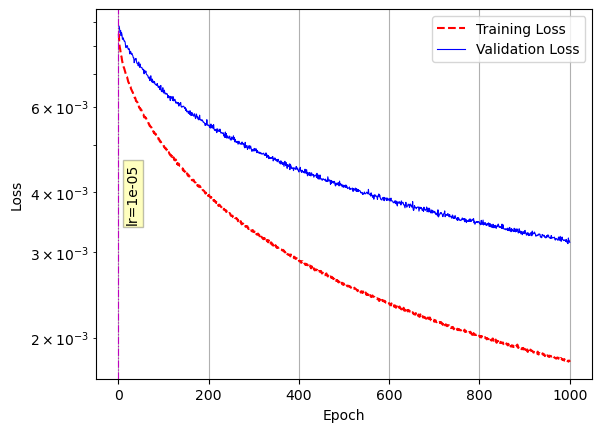



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
29/29 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0012 - covmat_fro_loss: 0.0020 - tot_time: 0h 0m 49.4s

Epoch 1: val_loss improved from inf to 0.01243, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 49s 

29/29 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0010 - covmat_fro_loss: 0.0018  - tot_time: 0h 2m 8.6s

Epoch 14: val_loss improved from 0.01186 to 0.01180, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 218ms/step - loss: 0.0094 - mse: 0.0010 - covmat_fro_loss: 0.0018 - val_loss: 0.0118 - val_mse: 0.0013 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
29/29 [==============================] - ETA: 0s - loss: 0.0094 - mse: 0.0010 - covmat_fro_loss: 0.0018  - tot_time: 0h 2m 14.7s

Epoch 15: val_loss did not improve from 0.01180
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [======================

Epoch 29/1000
29/29 [==============================] - ETA: 0s - loss: 0.0087 - mse: 9.2824e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 3m 41.2s

Epoch 29: val_loss improved from 0.01156 to 0.01147, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 219ms/step - loss: 0.0087 - mse: 9.2824e-04 - covmat_fro_loss: 0.0017 - val_loss: 0.0115 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 30/1000
29/29 [==============================] - ETA: 0s - loss: 0.0088 - mse: 9.3699e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 3m 47.4s

Epoch 30: val_loss did not improve from 0.01147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/2

29/29 [==============================] - ETA: 0s - loss: 0.0084 - mse: 8.8827e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 5m 13.1s

Epoch 44: val_loss did not improve from 0.01138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0084 - mse: 8.8827e-04 - covmat_fro_loss: 0.0017 - val_loss: 0.0116 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 45/1000
29/29 [==============================] - ETA: 0s - loss: 0.0083 - mse: 8.8285e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 5m 19.5s

Epoch 45: val_loss did not improve from 0.01138
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0083 - mse: 8.8285e-04 - covmat_fro_loss: 0.0017 - val_loss: 0.0115 - val_mse: 0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 216ms/step - loss: 0.0080 - mse: 8.4756e-04 - covmat_fro_loss: 0.0017 - val_loss: 0.0114 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 60/1000
29/29 [==============================] - ETA: 0s - loss: 0.0081 - mse: 8.5076e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 6m 51.1s

Epoch 60: val_loss did not improve from 0.01130
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0081 - mse: 8.5076e-04 - covmat_fro_loss: 0.0017 - val_loss: 0.0113 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 61/1000
29/29 [==============================] - ETA: 0s - loss: 0.0079 - mse: 8.3897e-04 - covmat_fro_loss: 0.0017 - tot_time: 0h 6m 5

Epoch 74/1000
29/29 [==============================] - ETA: 0s - loss: 0.0079 - mse: 8.2905e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 8m 17.5s

Epoch 74: val_loss did not improve from 0.01115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0079 - mse: 8.2905e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.0116 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 75/1000
29/29 [==============================] - ETA: 0s - loss: 0.0078 - mse: 8.2068e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 8m 23.6s

Epoch 75: val_loss did not improve from 0.01115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0078 - mse: 8.2068e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.011

Epoch 90/1000
29/29 [==============================] - ETA: 0s - loss: 0.0076 - mse: 7.9943e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 9m 54.7s

Epoch 90: val_loss did not improve from 0.01115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0076 - mse: 7.9943e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.0113 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 91/1000
29/29 [==============================] - ETA: 0s - loss: 0.0075 - mse: 7.9472e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 10m 1.0s

Epoch 91: val_loss did not improve from 0.01115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 219ms/step - loss: 0.0075 - mse: 7.9472e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.011

Epoch 105/1000
29/29 [==============================] - ETA: 0s - loss: 0.0073 - mse: 7.7111e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 11m 27.2s

Epoch 105: val_loss did not improve from 0.01083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0073 - mse: 7.7111e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.0113 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 106/1000
29/29 [==============================] - ETA: 0s - loss: 0.0073 - mse: 7.6819e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 11m 33.2s

Epoch 106: val_loss did not improve from 0.01083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0073 - mse: 7.6819e-04 - covmat_fro_loss: 0.0016 - val_loss:

Epoch 121/1000
29/29 [==============================] - ETA: 0s - loss: 0.0071 - mse: 7.4682e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 13m 5.1s

Epoch 121: val_loss improved from 0.01083 to 0.01077, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0071 - mse: 7.4682e-04 - covmat_fro_loss: 0.0016 - val_loss: 0.0108 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 122/1000
29/29 [==============================] - ETA: 0s - loss: 0.0072 - mse: 7.5329e-04 - covmat_fro_loss: 0.0016 - tot_time: 0h 13m 11.3s

Epoch 122: val_loss did not improve from 0.01077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps

Epoch 136/1000
29/29 [==============================] - ETA: 0s - loss: 0.0069 - mse: 7.2765e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 14m 37.1s

Epoch 136: val_loss did not improve from 0.01074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0069 - mse: 7.2765e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0109 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 137/1000
29/29 [==============================] - ETA: 0s - loss: 0.0069 - mse: 7.2620e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 14m 43.2s

Epoch 137: val_loss did not improve from 0.01074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0069 - mse: 7.2620e-04 - covmat_fro_loss: 0.0015 - val_loss:

29/29 [==============================] - ETA: 0s - loss: 0.0068 - mse: 7.1691e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 16m 9.1s

Epoch 151: val_loss did not improve from 0.01063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0068 - mse: 7.1691e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0108 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 152/1000
29/29 [==============================] - ETA: 0s - loss: 0.0068 - mse: 7.1059e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 16m 15.2s

Epoch 152: val_loss did not improve from 0.01063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0068 - mse: 7.1059e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0107 - val_ms

29/29 [==============================] - ETA: 0s - loss: 0.0066 - mse: 6.9248e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 17m 40.3s

Epoch 166: val_loss did not improve from 0.01050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 215ms/step - loss: 0.0066 - mse: 6.9248e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0106 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 167/1000
29/29 [==============================] - ETA: 0s - loss: 0.0066 - mse: 6.9118e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 17m 46.4s

Epoch 167: val_loss improved from 0.01050 to 0.01043, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0066 - mse: 6.8399e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0107 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 182/1000
29/29 [==============================] - ETA: 0s - loss: 0.0065 - mse: 6.7445e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 19m 16.8s

Epoch 182: val_loss did not improve from 0.01043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 208ms/step - loss: 0.0065 - mse: 6.7445e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0108 - val_mse: 0.0012 - val_covmat_fro_loss: 0.0000e+00
Epoch 183/1000
29/29 [==============================] - ETA: 0s - loss: 0.0065 - mse: 6.7697e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 

Epoch 197/1000
29/29 [==============================] - ETA: 0s - loss: 0.0064 - mse: 6.7271e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 20m 47.7s

Epoch 197: val_loss did not improve from 0.01036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/step - loss: 0.0064 - mse: 6.7271e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0104 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 198/1000
29/29 [==============================] - ETA: 0s - loss: 0.0064 - mse: 6.6387e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 20m 53.6s

Epoch 198: val_loss did not improve from 0.01036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms/step - loss: 0.0064 - mse: 6.6387e-04 - covmat_fro_loss: 0.0015 - val_loss:

Epoch 213/1000
29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 6.4462e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 22m 23.8s

Epoch 213: val_loss did not improve from 0.01036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0062 - mse: 6.4462e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0104 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 214/1000
29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 6.4896e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 22m 29.8s

Epoch 214: val_loss improved from 0.01036 to 0.01025, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outstep

29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 6.4367e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 23m 53.3s

Epoch 228: val_loss did not improve from 0.01025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0062 - mse: 6.4367e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0107 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 229/1000
29/29 [==============================] - ETA: 0s - loss: 0.0062 - mse: 6.4576e-04 - covmat_fro_loss: 0.0015 - tot_time: 0h 23m 59.3s

Epoch 229: val_loss did not improve from 0.01025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0062 - mse: 6.4576e-04 - covmat_fro_loss: 0.0015 - val_loss: 0.0105 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 200ms/step - loss: 0.0061 - mse: 6.3281e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0104 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 244/1000
29/29 [==============================] - ETA: 0s - loss: 0.0061 - mse: 6.3676e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 25m 27.9s

Epoch 244: val_loss did not improve from 0.01015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 199ms/step - loss: 0.0061 - mse: 6.3676e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0105 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 245/1000
29/29 [==============================] - ETA: 0s - loss: 0.0060 - mse: 6.2314e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 

Epoch 259/1000
29/29 [==============================] - ETA: 0s - loss: 0.0060 - mse: 6.1798e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 26m 55.6s

Epoch 259: val_loss did not improve from 0.01015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0060 - mse: 6.1798e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0103 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 260/1000
29/29 [==============================] - ETA: 0s - loss: 0.0059 - mse: 6.1495e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 27m 1.6s

Epoch 260: val_loss did not improve from 0.01015
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0059 - mse: 6.1495e-04 - covmat_fro_loss: 0.0014 - val_loss: 

29/29 [==============================] - ETA: 0s - loss: 0.0059 - mse: 6.0923e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 28m 25.1s

Epoch 274: val_loss did not improve from 0.01011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0059 - mse: 6.0923e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0103 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 275/1000
29/29 [==============================] - ETA: 0s - loss: 0.0058 - mse: 6.0555e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 28m 31.2s

Epoch 275: val_loss did not improve from 0.01011
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0058 - mse: 6.0555e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0103 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0058 - mse: 5.9669e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0102 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 290/1000
29/29 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.9647e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 30m 2.7s

Epoch 290: val_loss did not improve from 0.01007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0058 - mse: 5.9647e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0101 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 291/1000
29/29 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.9621e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 3

Epoch 305/1000
29/29 [==============================] - ETA: 0s - loss: 0.0057 - mse: 5.8789e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 31m 34.5s

Epoch 305: val_loss did not improve from 0.00995
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms/step - loss: 0.0057 - mse: 5.8789e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0102 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 306/1000
29/29 [==============================] - ETA: 0s - loss: 0.0056 - mse: 5.8384e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 31m 40.6s

Epoch 306: val_loss did not improve from 0.00995
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0056 - mse: 5.8384e-04 - covmat_fro_loss: 0.0014 - val_loss:

29/29 [==============================] - ETA: 0s - loss: 0.0056 - mse: 5.8108e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 33m 6.3s

Epoch 320: val_loss did not improve from 0.00990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0056 - mse: 5.8108e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0101 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 321/1000
29/29 [==============================] - ETA: 0s - loss: 0.0056 - mse: 5.8280e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 33m 12.4s

Epoch 321: val_loss did not improve from 0.00990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0056 - mse: 5.8280e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0100 - val_ms

Epoch 336/1000
29/29 [==============================] - ETA: 0s - loss: 0.0055 - mse: 5.6794e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 34m 43.3s

Epoch 336: val_loss did not improve from 0.00990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0055 - mse: 5.6794e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0101 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 337/1000
29/29 [==============================] - ETA: 0s - loss: 0.0055 - mse: 5.7006e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 34m 49.3s

Epoch 337: val_loss did not improve from 0.00990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 208ms/step - loss: 0.0055 - mse: 5.7006e-04 - covmat_fro_loss: 0.0014 - val_loss:

29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.6104e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 36m 15.3s

Epoch 351: val_loss did not improve from 0.00985
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 218ms/step - loss: 0.0054 - mse: 5.6104e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0099 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 352/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.5846e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 36m 21.6s

Epoch 352: val_loss did not improve from 0.00985
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0054 - mse: 5.5846e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0101 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms/step - loss: 0.0054 - mse: 5.5672e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0101 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 367/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.5374e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 37m 53.4s

Epoch 367: val_loss did not improve from 0.00982
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 217ms/step - loss: 0.0054 - mse: 5.5374e-04 - covmat_fro_loss: 0.0014 - val_loss: 0.0100 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 368/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.5493e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 

Epoch 382/1000
29/29 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.5379e-04 - covmat_fro_loss: 0.0014 - tot_time: 0h 39m 25.1s

Epoch 382: val_loss did not improve from 0.00973
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0054 - mse: 5.5379e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0099 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 383/1000
29/29 [==============================] - ETA: 0s - loss: 0.0053 - mse: 5.4589e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 39m 31.1s

Epoch 383: val_loss did not improve from 0.00973
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0053 - mse: 5.4589e-04 - covmat_fro_loss: 0.0013 - val_loss:

Epoch 398/1000
29/29 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.3841e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 41m 2.9s

Epoch 398: val_loss did not improve from 0.00973
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 216ms/step - loss: 0.0052 - mse: 5.3841e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0099 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 399/1000
29/29 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.3619e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 41m 9.1s

Epoch 399: val_loss did not improve from 0.00973
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0052 - mse: 5.3619e-04 - covmat_fro_loss: 0.0013 - val_loss: 0

29/29 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.3346e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 42m 34.2s

Epoch 413: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 216ms/step - loss: 0.0052 - mse: 5.3346e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0099 - val_mse: 0.0011 - val_covmat_fro_loss: 0.0000e+00
Epoch 414/1000
29/29 [==============================] - ETA: 0s - loss: 0.0052 - mse: 5.3230e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 42m 40.3s

Epoch 414: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0052 - mse: 5.3230e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_m

Epoch 429/1000
29/29 [==============================] - ETA: 0s - loss: 0.0051 - mse: 5.2553e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 44m 12.0s

Epoch 429: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0051 - mse: 5.2553e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0098 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 430/1000
29/29 [==============================] - ETA: 0s - loss: 0.0051 - mse: 5.2051e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 44m 18.0s

Epoch 430: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0051 - mse: 5.2051e-04 - covmat_fro_loss: 0.0013 - val_loss:

Epoch 445/1000
29/29 [==============================] - ETA: 0s - loss: 0.0051 - mse: 5.2002e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 45m 49.6s

Epoch 445: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0051 - mse: 5.2002e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0098 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 446/1000
29/29 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.1652e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 45m 55.5s

Epoch 446: val_loss did not improve from 0.00963
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0050 - mse: 5.1652e-04 - covmat_fro_loss: 0.0013 - val_loss:

29/29 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.1297e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 47m 20.7s

Epoch 460: val_loss did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 208ms/step - loss: 0.0050 - mse: 5.1297e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 461/1000
29/29 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.1463e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 47m 26.9s

Epoch 461: val_loss did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 217ms/step - loss: 0.0050 - mse: 5.1463e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_m

Epoch 476/1000
29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.0430e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 48m 58.4s

Epoch 476: val_loss did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0049 - mse: 5.0430e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0098 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 477/1000
29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.0363e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 49m 4.4s

Epoch 477: val_loss did not improve from 0.00959
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms/step - loss: 0.0049 - mse: 5.0363e-04 - covmat_fro_loss: 0.0013 - val_loss: 

29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 5.0129e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 50m 29.9s

Epoch 491: val_loss did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0049 - mse: 5.0129e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0098 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 492/1000
29/29 [==============================] - ETA: 0s - loss: 0.0049 - mse: 4.9892e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 50m 35.9s

Epoch 492: val_loss did not improve from 0.00954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0049 - mse: 4.9892e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0099 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0049 - mse: 5.0012e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 507/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.9478e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 52m 6.6s

Epoch 507: val_loss did not improve from 0.00950
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/step - loss: 0.0048 - mse: 4.9478e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 508/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.9410e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 5

Epoch 522/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.8680e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 53m 39.1s

Epoch 522: val_loss did not improve from 0.00950
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0048 - mse: 4.8680e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 523/1000
29/29 [==============================] - ETA: 0s - loss: 0.0048 - mse: 4.9415e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 53m 45.2s

Epoch 523: val_loss did not improve from 0.00950
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0048 - mse: 4.9415e-04 - covmat_fro_loss: 0.0013 - val_loss:

Epoch 537/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.8256e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 55m 11.1s

Epoch 537: val_loss did not improve from 0.00945
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0047 - mse: 4.8256e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0096 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 538/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.8211e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 55m 17.3s

Epoch 538: val_loss did not improve from 0.00945
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0047 - mse: 4.8211e-04 - covmat_fro_loss: 0.0013 - val_loss:

29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7607e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 56m 42.1s

Epoch 552: val_loss did not improve from 0.00944
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0047 - mse: 4.7607e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0095 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 553/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7317e-04 - covmat_fro_loss: 0.0012 - tot_time: 0h 56m 48.0s

Epoch 553: val_loss improved from 0.00944 to 0.00939, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0047 - mse: 4.8183e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 568/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7747e-04 - covmat_fro_loss: 0.0013 - tot_time: 0h 58m 20.9s

Epoch 568: val_loss did not improve from 0.00939
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0047 - mse: 4.7747e-04 - covmat_fro_loss: 0.0013 - val_loss: 0.0097 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 569/1000
29/29 [==============================] - ETA: 0s - loss: 0.0047 - mse: 4.7393e-04 - covmat_fro_loss: 0.0012 - tot_time: 0h 

Epoch 583/1000
29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 4.6560e-04 - covmat_fro_loss: 0.0012 - tot_time: 0h 59m 52.5s

Epoch 583: val_loss did not improve from 0.00934
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0046 - mse: 4.6560e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0096 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 584/1000
29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 4.7020e-04 - covmat_fro_loss: 0.0012 - tot_time: 0h 59m 58.6s

Epoch 584: val_loss did not improve from 0.00934
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0046 - mse: 4.7020e-04 - covmat_fro_loss: 0.0012 - val_loss:

Epoch 599/1000
29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 4.6563e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 1m 30.1s

Epoch 599: val_loss did not improve from 0.00934
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0046 - mse: 4.6563e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0096 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 600/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5919e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 1m 36.2s

Epoch 600: val_loss improved from 0.00934 to 0.00931, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps


29/29 [==============================] - ETA: 0s - loss: 0.0046 - mse: 4.6231e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 3m 2.6s

Epoch 614: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0046 - mse: 4.6231e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0095 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 615/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5886e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 3m 8.4s

Epoch 615: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 201ms/step - loss: 0.0045 - mse: 4.5886e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0094 - val_mse: 

Epoch 630/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5235e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 4m 40.7s

Epoch 630: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 215ms/step - loss: 0.0045 - mse: 4.5235e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0093 - val_mse: 9.9080e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 631/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5223e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 4m 46.9s

Epoch 631: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0045 - mse: 4.5223e-04 - covmat_fro_loss: 0.0012 - val_los

Epoch 646/1000
29/29 [==============================] - ETA: 0s - loss: 0.0045 - mse: 4.5198e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 6m 18.6s

Epoch 646: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 218ms/step - loss: 0.0045 - mse: 4.5198e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0094 - val_mse: 9.9887e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 647/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4901e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 6m 25.0s

Epoch 647: val_loss did not improve from 0.00931
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 221ms/step - loss: 0.0044 - mse: 4.4901e-04 - covmat_fro_loss: 0.0012 - val_los

Epoch 661/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4336e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 7m 51.3s

Epoch 661: val_loss did not improve from 0.00917
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 218ms/step - loss: 0.0044 - mse: 4.4336e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0094 - val_mse: 0.0010 - val_covmat_fro_loss: 0.0000e+00
Epoch 662/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4403e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 7m 57.5s

Epoch 662: val_loss did not improve from 0.00917
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 215ms/step - loss: 0.0044 - mse: 4.4403e-04 - covmat_fro_loss: 0.0012 - val_loss: 0

Epoch 677/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4225e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 9m 28.7s

Epoch 677: val_loss did not improve from 0.00917
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0044 - mse: 4.4225e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0094 - val_mse: 9.9897e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 678/1000
29/29 [==============================] - ETA: 0s - loss: 0.0044 - mse: 4.4209e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 9m 34.9s

Epoch 678: val_loss did not improve from 0.00917
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0044 - mse: 4.4209e-04 - covmat_fro_loss: 0.0012 - val_los

29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3823e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 11m 1.0s

Epoch 692: val_loss did not improve from 0.00911
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 205ms/step - loss: 0.0043 - mse: 4.3823e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.8022e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 693/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3691e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 11m 7.1s

Epoch 693: val_loss did not improve from 0.00911
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0043 - mse: 4.3691e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0094 - val

Epoch 708/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3000e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 12m 39.7s

Epoch 708: val_loss did not improve from 0.00911
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0043 - mse: 4.3000e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0093 - val_mse: 9.8972e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 709/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3048e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 12m 45.8s

Epoch 709: val_loss did not improve from 0.00911
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0043 - mse: 4.3048e-04 - covmat_fro_loss: 0.0012 - val_l

29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.3085e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 14m 13.1s

Epoch 723: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0043 - mse: 4.3085e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.7336e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 724/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2537e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 14m 19.1s

Epoch 724: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0042 - mse: 4.2537e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - v

Epoch 739/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2242e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 15m 52.3s

Epoch 739: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0042 - mse: 4.2242e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.7858e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 740/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2584e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 15m 58.3s

Epoch 740: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 210ms/step - loss: 0.0042 - mse: 4.2584e-04 - covmat_fro_loss: 0.0012 - val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0042 - mse: 4.1863e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0093 - val_mse: 9.9469e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 755/1000
29/29 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.2831e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 17m 29.8s

Epoch 755: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 202ms/step - loss: 0.0043 - mse: 4.2831e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0093 - val_mse: 9.8431e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 756/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.2309e-04 - covmat_fro_loss: 0.0012 - tot_t

Epoch 770/1000
29/29 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.1989e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 19m 1.1s

Epoch 770: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0042 - mse: 4.1989e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.7668e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 771/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1677e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 19m 7.3s

Epoch 771: val_loss did not improve from 0.00906
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0041 - mse: 4.1677e-04 - covmat_fro_loss: 0.0012 - val_los

29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1575e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 20m 33.6s

Epoch 785: val_loss did not improve from 0.00894
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0041 - mse: 4.1575e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.8075e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 786/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1350e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 20m 39.6s

Epoch 786: val_loss did not improve from 0.00894
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0041 - mse: 4.1350e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - v

29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.1103e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 22m 5.1s

Epoch 800: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 217ms/step - loss: 0.0041 - mse: 4.1103e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0092 - val_mse: 9.7339e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 801/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.0731e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 22m 11.1s

Epoch 801: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0041 - mse: 4.0731e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0091 - va

Epoch 816/1000
29/29 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.0788e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 23m 43.1s

Epoch 816: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 219ms/step - loss: 0.0041 - mse: 4.0788e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0091 - val_mse: 9.6331e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 817/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.0522e-04 - covmat_fro_loss: 0.0012 - tot_time: 1h 23m 49.2s

Epoch 817: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0040 - mse: 4.0522e-04 - covmat_fro_loss: 0.0012 - val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 218ms/step - loss: 0.0041 - mse: 4.0659e-04 - covmat_fro_loss: 0.0012 - val_loss: 0.0091 - val_mse: 9.7166e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 832/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.0158e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 25m 20.6s

Epoch 832: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0040 - mse: 4.0158e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.5747e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 833/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 4.0270e-04 - covmat_fro_loss: 0.0011 - tot_t

Epoch 847/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.9722e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 26m 52.7s

Epoch 847: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0040 - mse: 3.9722e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.5747e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 848/1000
29/29 [==============================] - ETA: 0s - loss: 0.0040 - mse: 3.9938e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 26m 58.7s

Epoch 848: val_loss did not improve from 0.00891
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0040 - mse: 3.9938e-04 - covmat_fro_loss: 0.0011 - val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 204ms/step - loss: 0.0039 - mse: 3.9377e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0089 - val_mse: 9.4902e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 863/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.9288e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 28m 30.6s

Epoch 863: val_loss improved from 0.00891 to 0.00881, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 215ms/step - loss: 0.0039 - mse: 3.9288e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0088 - val_mse: 9.3440e-04 - val_covmat_fro_loss: 0.0000e+00
Epo

Epoch 878/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.9221e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 30m 2.1s

Epoch 878: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 216ms/step - loss: 0.0039 - mse: 3.9221e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.5218e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 879/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.9203e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 30m 8.5s

Epoch 879: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0039 - mse: 3.9203e-04 - covmat_fro_loss: 0.0011 - val_los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 212ms/step - loss: 0.0039 - mse: 3.9003e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0091 - val_mse: 9.6660e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 894/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.9104e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 31m 39.6s

Epoch 894: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 215ms/step - loss: 0.0039 - mse: 3.9104e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.5629e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 895/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.9027e-04 - covmat_fro_loss: 0.0011 - tot_t

Epoch 909/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.8654e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 33m 10.3s

Epoch 909: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 213ms/step - loss: 0.0039 - mse: 3.8654e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0089 - val_mse: 9.4378e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 910/1000
29/29 [==============================] - ETA: 0s - loss: 0.0039 - mse: 3.8659e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 33m 16.2s

Epoch 910: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 203ms/step - loss: 0.0039 - mse: 3.8659e-04 - covmat_fro_loss: 0.0011 - val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0039 - mse: 3.8487e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.6126e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 925/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.8187e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 34m 46.7s

Epoch 925: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 207ms/step - loss: 0.0038 - mse: 3.8187e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0089 - val_mse: 9.4814e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 926/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.8027e-04 - covmat_fro_loss: 0.0011 - tot_t

Epoch 940/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7879e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 36m 18.9s

Epoch 940: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 219ms/step - loss: 0.0038 - mse: 3.7879e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0090 - val_mse: 9.5137e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 941/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7930e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 36m 25.4s

Epoch 941: val_loss did not improve from 0.00881
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 220ms/step - loss: 0.0038 - mse: 3.7930e-04 - covmat_fro_loss: 0.0011 - val_l

Epoch 955/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7587e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 37m 51.4s

Epoch 955: val_loss did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 206ms/step - loss: 0.0038 - mse: 3.7587e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0089 - val_mse: 9.4300e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 956/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7780e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 37m 57.6s

Epoch 956: val_loss did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 214ms/step - loss: 0.0038 - mse: 3.7780e-04 - covmat_fro_loss: 0.0011 - val_l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 211ms/step - loss: 0.0037 - mse: 3.7226e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0088 - val_mse: 9.3039e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 971/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7327e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 39m 29.3s

Epoch 971: val_loss did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0038 - mse: 3.7327e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0089 - val_mse: 9.4722e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 972/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7586e-04 - covmat_fro_loss: 0.0011 - tot_t

Epoch 986/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7331e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 40m 57.9s

Epoch 986: val_loss did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 209ms/step - loss: 0.0038 - mse: 3.7331e-04 - covmat_fro_loss: 0.0011 - val_loss: 0.0088 - val_mse: 9.3625e-04 - val_covmat_fro_loss: 0.0000e+00
Epoch 987/1000
29/29 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.7280e-04 - covmat_fro_loss: 0.0011 - tot_time: 1h 41m 3.7s

Epoch 987: val_loss did not improve from 0.00873
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-30_outsteps
29/29 [==============================] - 6s 198ms/step - loss: 0.0038 - mse: 3.7280e-04 - covmat_fro_loss: 0.0011 - val_lo

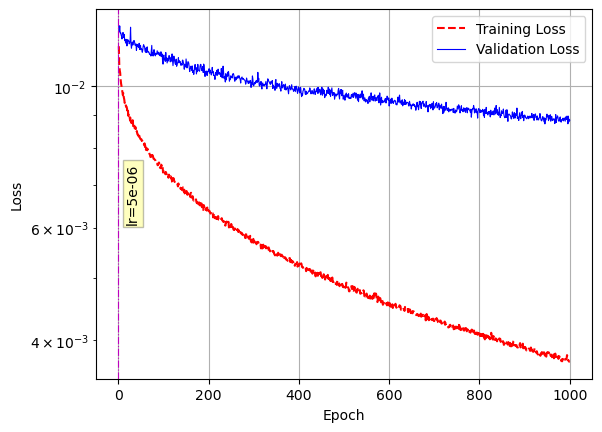



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0021 - covmat_fro_loss: 0.0035 - tot_time: 0h 1m 21.7s

Epoch 1: val_loss improved from inf to 0.02308, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 82s 

Epoch 15/1000
24/24 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0018 - covmat_fro_loss: 0.0033 - tot_time: 0h 2m 52.6s

Epoch 15: val_loss did not improve from 0.02245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 268ms/step - loss: 0.0165 - mse: 0.0018 - covmat_fro_loss: 0.0033 - val_loss: 0.0226 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 16/1000
24/24 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0018 - covmat_fro_loss: 0.0033 - tot_time: 0h 2m 58.8s

Epoch 16: val_loss did not improve from 0.02245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 261ms/step - loss: 0.0164 - mse: 0.0018 - covmat_fro_loss: 0.0033 - val_loss: 0.0230 - val_mse: 0.0

Epoch 31/1000
24/24 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0017 - covmat_fro_loss: 0.0032 - tot_time: 0h 4m 34.5s

Epoch 31: val_loss did not improve from 0.02240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 262ms/step - loss: 0.0153 - mse: 0.0017 - covmat_fro_loss: 0.0032 - val_loss: 0.0224 - val_mse: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 32/1000
24/24 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0017 - covmat_fro_loss: 0.0032 - tot_time: 0h 4m 41.0s

Epoch 32: val_loss did not improve from 0.02240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 270ms/step - loss: 0.0153 - mse: 0.0017 - covmat_fro_loss: 0.0032 - val_loss: 0.0226 - val_mse: 0.0

Epoch 47/1000
24/24 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0016 - covmat_fro_loss: 0.0031 - tot_time: 0h 6m 16.0s

Epoch 47: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 260ms/step - loss: 0.0147 - mse: 0.0016 - covmat_fro_loss: 0.0031 - val_loss: 0.0230 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 48/1000
24/24 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0016 - covmat_fro_loss: 0.0031 - tot_time: 0h 6m 22.2s

Epoch 48: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 261ms/step - loss: 0.0147 - mse: 0.0016 - covmat_fro_loss: 0.0031 - val_loss: 0.0229 - val_mse: 0.0

Epoch 63/1000
24/24 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0015 - covmat_fro_loss: 0.0031 - tot_time: 0h 7m 57.7s

Epoch 63: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 263ms/step - loss: 0.0141 - mse: 0.0015 - covmat_fro_loss: 0.0031 - val_loss: 0.0225 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 64/1000
24/24 [==============================] - ETA: 0s - loss: 0.0143 - mse: 0.0015 - covmat_fro_loss: 0.0031 - tot_time: 0h 8m 4.0s

Epoch 64: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 262ms/step - loss: 0.0143 - mse: 0.0015 - covmat_fro_loss: 0.0031 - val_loss: 0.0229 - val_mse: 0.00

Epoch 79/1000
24/24 [==============================] - ETA: 0s - loss: 0.0138 - mse: 0.0015 - covmat_fro_loss: 0.0030 - tot_time: 0h 9m 39.8s

Epoch 79: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 263ms/step - loss: 0.0138 - mse: 0.0015 - covmat_fro_loss: 0.0030 - val_loss: 0.0227 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 80/1000
24/24 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0015 - covmat_fro_loss: 0.0030 - tot_time: 0h 9m 45.9s

Epoch 80: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 255ms/step - loss: 0.0139 - mse: 0.0015 - covmat_fro_loss: 0.0030 - val_loss: 0.0225 - val_mse: 0.0

Epoch 95/1000
24/24 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0015 - covmat_fro_loss: 0.0030 - tot_time: 0h 11m 21.0s

Epoch 95: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 264ms/step - loss: 0.0135 - mse: 0.0015 - covmat_fro_loss: 0.0030 - val_loss: 0.0228 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 96/1000
24/24 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0015 - covmat_fro_loss: 0.0030 - tot_time: 0h 11m 27.2s

Epoch 96: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 260ms/step - loss: 0.0135 - mse: 0.0015 - covmat_fro_loss: 0.0030 - val_loss: 0.0228 - val_mse: 0

Epoch 111/1000
24/24 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0014 - covmat_fro_loss: 0.0030 - tot_time: 0h 13m 2.0s

Epoch 111: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 266ms/step - loss: 0.0132 - mse: 0.0014 - covmat_fro_loss: 0.0030 - val_loss: 0.0231 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 112/1000
24/24 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0014 - covmat_fro_loss: 0.0030 - tot_time: 0h 13m 8.3s

Epoch 112: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 264ms/step - loss: 0.0132 - mse: 0.0014 - covmat_fro_loss: 0.0030 - val_loss: 0.0226 - val_mse:

Epoch 127/1000
24/24 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0014 - covmat_fro_loss: 0.0030 - tot_time: 0h 14m 43.4s

Epoch 127: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 7s 274ms/step - loss: 0.0130 - mse: 0.0014 - covmat_fro_loss: 0.0030 - val_loss: 0.0230 - val_mse: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 128/1000
24/24 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0014 - covmat_fro_loss: 0.0030 - tot_time: 0h 14m 49.6s

Epoch 128: val_loss did not improve from 0.02217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_001/checkpoints/LossHistoriesCheckpoint-50_outsteps
24/24 [==============================] - 6s 261ms/step - loss: 0.0130 - mse: 0.0014 - covmat_fro_loss: 0.0030 - val_loss: 0.0229 - val_ms

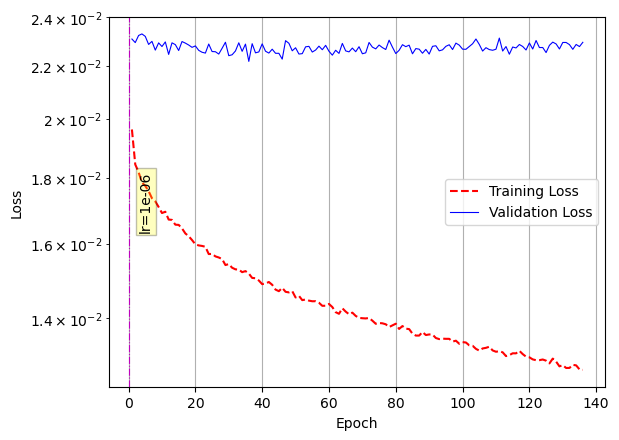

In [21]:
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    AR_AERNN = trainAERNN(
        create_data_for_RNN,
        ae_net,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=stateful,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)

    ae_net = AR_AERNN.ae_net

In [22]:
### Training the combined AE-RNN
